# PPO for Portfolio Management
This tutorial is to demonstrate an example of using PPO to do portfolio management

## Step1: Import Packages

In [1]:

import warnings
warnings.filterwarnings("ignore")
import sys
from pathlib import Path
import os
import torch

ROOT = os.path.dirname(os.path.abspath("."))
sys.path.append(ROOT)

import argparse
import os.path as osp
from mmcv import Config
from trademaster.utils import replace_cfg_vals
from trademaster.nets.builder import build_net
from trademaster.environments.builder import build_environment
from trademaster.datasets.builder import build_dataset
from trademaster.agents.builder import build_agent
from trademaster.optimizers.builder import build_optimizer
from trademaster.losses.builder import build_loss
from trademaster.trainers.builder import build_trainer
from trademaster.utils import plot
from trademaster.utils import set_seed
set_seed(2023)

2023-03-04 01:01:12,046	INFO services.py:1476 -- View the Ray dashboard at http://127.0.0.1:8265
2023-03-04 01:01:14,276	INFO worker.py:973 -- Calling ray.init() again after it has already been called.


## Step2: Import Configs

In [2]:
parser = argparse.ArgumentParser(description='Download Alpaca Datasets')
parser.add_argument("--config", default=osp.join(ROOT, "configs", "portfolio_management", "portfolio_management_exchange_ppo_ppo_adam_mse.py"),
                    help="download datasets config file path")
parser.add_argument("--task_name", type=str, default="train")
args, _ = parser.parse_known_args()

cfg = Config.fromfile(args.config)
task_name = args.task_name
cfg = replace_cfg_vals(cfg)

## Step3: Build Dataset

In [3]:
dataset = build_dataset(cfg)


## Step4: Build Trainer

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
work_dir = os.path.join(ROOT, cfg.trainer.work_dir)

if not os.path.exists(work_dir):
    os.makedirs(work_dir)
cfg.dump(osp.join(work_dir, osp.basename(args.config)))

trainer = build_trainer(cfg, default_args=dict(dataset=dataset, device = device))

| Arguments Keep work_dir: /data/sunshuo/qml/TradeMaster/work_dir/portfolio_management_exchange_ppo_ppo_adam_mse


## Step5: Train, Valid and Test

In [5]:
trainer.train_and_valid()

2023-03-04 01:01:16,488	INFO trainer.py:2322 -- Executing eagerly (framework='tf2'), with eager_tracing=False. For production workloads, make sure to set eager_tracing=True  in order to match the speed of tf-static-graph (framework='tf'). For debugging purposes, `eager_tracing=False` is the best choice.
2023-03-04 01:01:16,490	INFO trainer.py:906 -- Current log_level is WARN. For more information, set 'log_level': 'INFO' / 'DEBUG' or use the -v and -vv flags.
2023-03-04 01:01:16,744	WARNING env.py:136 -- Your env doesn't have a .spec.max_episode_steps attribute. This is fine if you have set 'horizon' in your config dictionary, or `soft_horizon`. However, if you haven't, 'horizon' will default to infinity, and your environment will not be reset.
2023-03-04 01:01:26,132	WARNING util.py:65 -- Install gputil for GPU system monitoring.


Train Episode: [1/2]


2023-03-04 01:02:29,571	WARNING deprecation.py:47 -- DeprecationWarning: `_get_slice_indices` has been deprecated. This will raise an error in the future!
2023-03-04 01:02:29,575	WARNING deprecation.py:47 -- DeprecationWarning: `slice` has been deprecated. Use `SampleBatch[start:stop]` instead. This will raise an error in the future!


Valid Episode: [1/2]
+--------------+-------------+------------+--------------+
| Total Return | Sharp Ratio | Volatility | Max Drawdown |
+--------------+-------------+------------+--------------+
|  2.219408%   |   4.572449  | 0.344591%  |  7.344060%   |
+--------------+-------------+------------+--------------+
Train Episode: [2/2]
+--------------+-------------+------------+--------------+
| Total Return | Sharp Ratio | Volatility | Max Drawdown |
+--------------+-------------+------------+--------------+
| -99.811304%  |  -61.369304 | 0.407410%  |  99.811304%  |
+--------------+-------------+------------+--------------+
Valid Episode: [2/2]
+--------------+-------------+------------+--------------+
| Total Return | Sharp Ratio | Volatility | Max Drawdown |
+--------------+-------------+------------+--------------+
|  2.414466%   |   4.979264  | 0.344248%  |  7.286024%   |
+--------------+-------------+------------+--------------+


In [6]:
import ray
from ray.tune.registry import register_env
from trademaster.environments.portfolio_management.environment import PortfolioManagementEnvironment
def env_creator(env_name):
    if env_name == 'portfolio_management':
        env = PortfolioManagementEnvironment
    else:
        raise NotImplementedError
    return env
ray.init(ignore_reinit_error=True)
register_env("portfolio_management", lambda config: env_creator("portfolio_management")(config))
trainer.test();

2023-03-04 01:05:24,872	INFO services.py:1476 -- View the Ray dashboard at http://127.0.0.1:8265
2023-03-04 01:05:27,630	WARNING env.py:136 -- Your env doesn't have a .spec.max_episode_steps attribute. This is fine if you have set 'horizon' in your config dictionary, or `soft_horizon`. However, if you haven't, 'horizon' will default to infinity, and your environment will not be reset.
2023-03-04 01:05:27,862	WARNING util.py:65 -- Install gputil for GPU system monitoring.
2023-03-04 01:05:27,890	WARNING eager_tf_policy.py:725 -- Cannot restore an optimizer's state for tf eager! Keras is not able to save the v1.x optimizers (from tf.compat.v1.train) since they aren't compatible with checkpoints.
2023-03-04 01:05:27,992	INFO trainable.py:589 -- Restored on 172.21.100.16 from checkpoint: /home/sunshuo/ray_results/PPOTrainer_portfolio_management_2023-03-04_01-05-276nqq6fio/tmp9840uf0yrestore_from_object/checkpoint-2
2023-03-04 01:05:27,993	INFO trainable.py:597 -- Current state after restor

Test Best Episode
+--------------+-------------+------------+--------------+
| Total Return | Sharp Ratio | Volatility | Max Drawdown |
+--------------+-------------+------------+--------------+
|  1.237377%   |  11.610471  | 0.170899%  |  1.678342%   |
+--------------+-------------+------------+--------------+


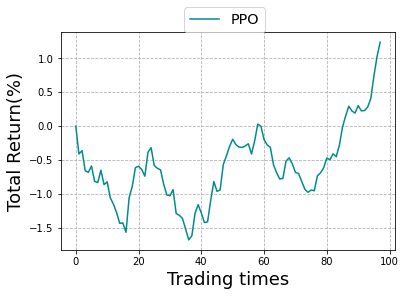

In [7]:
plot(trainer.test_environment.save_asset_memory(),alg="PPO")